<img src='https://radiant-assets.s3-us-west-2.amazonaws.com/PrimaryRadiantMLHubLogo.png' alt='Radiant MLHub Logo' width='300'/>

# 2021 NASA Harvest Rwanda Baseline Model

This notebook walks you through the steps to create a baseline field delineation model for detecting boundaries from sentinel-2 time-series satellite imagery using a spatio-temporal U-Net model on the 2021 NASA Harvest dataset.

### Dependencies

All the dependencies for this notebook are included in the `requirements.txt` file included in this folder.

In [5]:
# Importing the needed libraries
import getpass
import glob
import keras
import os
import pickle
import random
from radiant_mlhub import Dataset

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rasterio as rio
import tensorflow as tf
from pathlib import Path
from random import choice
from scipy.ndimage import gaussian_filter
from sklearn.model_selection import train_test_split
from keras import backend as K
from keras.layers import *
from keras.models import *
from keras.models import load_model
from keras.optimizers import *
from keras.preprocessing import image

from tensorflow.keras.layers import *
from tensorflow.keras.losses import *

from sklearn.model_selection import train_test_split

from typing import List, Any, Callable, Tuple

In [7]:
tf.config.list_physical_devices("CPU") #activate GPU resource for model training

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

In [9]:
dataset_id = 'nasa_rwanda_field_boundary_competition'
assets = ['labels']

In [9]:
#Append your MLHUB_API_KEY after this cell is executed to download dataset
os.environ['MLHUB_API_KEY'] =  getpass.getpass(prompt="MLHub API Key: ")
dataset = Dataset.fetch(dataset_id)

MLHub API Key:  ································································


In [10]:
dataset.download(if_exists='overwrite')

nasa_rwanda_field_boundary_competition: fetch stac catalog: 160KB [00:01, 143.58KB/s]                                                       
INFO:radiant_mlhub.client.catalog_downloader:unarchive nasa_rwanda_field_boundary_competition.tar.gz ...
INFO:radiant_mlhub.client.catalog_downloader:create stac asset list (please wait) ...
INFO:radiant_mlhub.client.catalog_downloader:1738 unique assets in stac catalog.
download assets: 100%|██████████████████████████████████████████████████████████████████████████████████| 1738/1738 [04:40<00:00,  6.19it/s]
INFO:radiant_mlhub.client.catalog_downloader:assets saved to /home/elie/gitclones/zindi_boundaries_classification/notebooks/nasa_rwanda_field_boundary_competition


In [10]:
#image snapshot dimensions
IMG_WIDTH = 256 
IMG_HEIGHT = 256 
IMG_CHANNELS = 4 #we have the rgba bands
dataset_id

'nasa_rwanda_field_boundary_competition'

We have two sets of data: the train and test dataset, each having a list of file ids belonging to them.
For model development purposes, we will use the training set(`train_tiles`) and use the test set for model prediction/evaluation.

In [11]:
train_source_items = f"{dataset_id}/{dataset_id}_source_train"
train_label_items = f"{dataset_id}/{dataset_id}_labels_train"

In [12]:
next(os.walk(train_source_items))[1][0]

'nasa_rwanda_field_boundary_competition_source_train_33_2021_11'

In [13]:
def clean_string(s: str) -> str:
    """
    extract the tile id and timestamp from a source image folder
    e.g extract 'ID_YYYY_MM' from 'nasa_rwanda_field_boundary_competition_source_train_ID_YYYY_MM'
    """
    s = s.replace(f"{dataset_id}_source_", '').split('_')[1:]
    return '_'.join(s)

In [15]:
train_tiles = [clean_string(s) for s in next(os.walk(train_source_items))[1]]
train_tiles[:3]


['33_2021_11', '34_2021_12', '48_2021_10']

Our source images have pixel values > 255, hence we need to apply normalisation on our images to generate a normalised image. We apply the min-max normalisation for this which is simply: $${\text{all pixel values - minimum pixel value} \over \text{maximum pixel value - minimum pixel value}}$$

In [16]:
def normalize(
    array: np.ndarray
):
    """ normalise image to give a meaningful output """
    array_min, array_max = array.min(), array.max()
    return (array - array_min) / (array_max - array_min)

### Data Augmentation

In this notebook, we will perform data augmentation on our normalised images. This will be used to populate the model with data to obtain even more accurate results.

We will employ the following data augmentation techniques on the dataset:
- rotation, flipping, blurring.

These techniques were thanks to the radix-ai GitHub repository, which can be accessed [here](https://github.com/radix-ai/agoro-field-boundary-detector).
We will observe the results on a random source image and its associated label below:

In [17]:
#loading the 4 bands of the image
tile = random.choice(train_tiles)
print(tile)
bd1 = rio.open(f"{train_source_items}/{dataset_id}_source_train_{tile}/B01.tif")
bd1_array = bd1.read(1)
bd2 = rio.open(f"{train_source_items}/{dataset_id}_source_train_{tile}/B02.tif")
bd2_array = bd2.read(1)
bd3 = rio.open(f"{train_source_items}/{dataset_id}_source_train_{tile}/B03.tif")
bd3_array = bd3.read(1)
bd4 = rio.open(f"{train_source_items}/{dataset_id}_source_train_{tile}/B04.tif")
bd4_array = bd4.read(1)
b01_norm = normalize(bd1_array)
b02_norm = normalize(bd2_array)
b03_norm = normalize(bd3_array)
b04_norm = normalize(bd4_array)

field = np.dstack((b04_norm, b03_norm, b02_norm, b01_norm))
mask  = rio.open(Path.cwd() / f"{train_label_items}/{dataset_id}_labels_train_{tile.split('_')[0]}/raster_labels.tif").read(1)

26_2021_11


In [18]:
#https://github.com/radix-ai/agoro-field-boundary-detector/tree/master/src/agoro_field_boundary_detector
def t_linear(
    field: np.ndarray,
    mask: np.ndarray,
    _: int = 0,
) -> Tuple[np.ndarray, np.ndarray]:
    """Apply a linear (i.e. no) transformation and save."""
    return field, mask

def t_rotation(
    field: np.ndarray,
    mask: np.ndarray,
    rot: int,
) -> Tuple[np.ndarray, np.ndarray]:
    """Rotate the data."""
    assert rot in range(0, 3 + 1)
    for _ in range(rot):
        field = np.rot90(field)
        mask = np.rot90(mask)
    return field, mask

def t_flip(
    field: np.ndarray,
    mask: np.ndarray,
    idx: int,
) -> Tuple[np.ndarray, np.ndarray]:
    """Flip the data."""
    assert idx in range(0, 2 + 1)
    if idx == 0:  # Diagonal
        field = np.rot90(np.fliplr(field))
        mask = np.rot90(np.fliplr(mask))
    if idx == 1:  # Horizontal
        field = np.flip(field, axis=0)
        mask = np.flip(mask, axis=0)
    if idx == 2:  # Vertical
        field = np.flip(field, axis=1)
        mask = np.flip(mask, axis=1)
    return field, mask

def t_blur(
    field: np.ndarray,
    mask: np.ndarray,
    sigma: int,
) -> Tuple[np.ndarray, np.ndarray]:
    """Blur the image by applying a Gaussian filter."""
    assert 0 <= sigma <= 10
    sigma_f = 1.0 + (sigma / 10)
    field = np.copy(field)
    for i in range(3):
        field[:, :, i] = gaussian_filter(field[:, :, i], sigma=sigma_f)
    return field, mask

In [19]:
def show_image(field:np.ndarray, mask:np.ndarray): 
    """Show the field and corresponding mask."""
    fig = plt.figure(figsize=(8,6))
    ax1 = fig.add_subplot(121)  # left side
    ax2 = fig.add_subplot(122)  # right side
    ax1.imshow(field[:,:,0:3])  # rgb band
    plt.gray()
    ax2.imshow(mask)
    plt.tight_layout()
    plt.show()

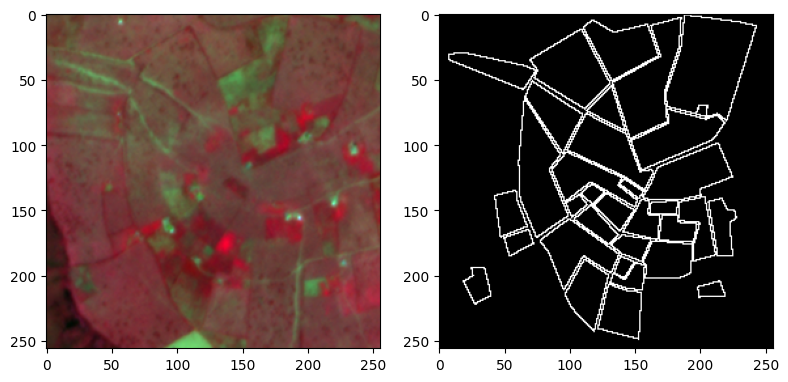

In [20]:
show_image(field, mask)

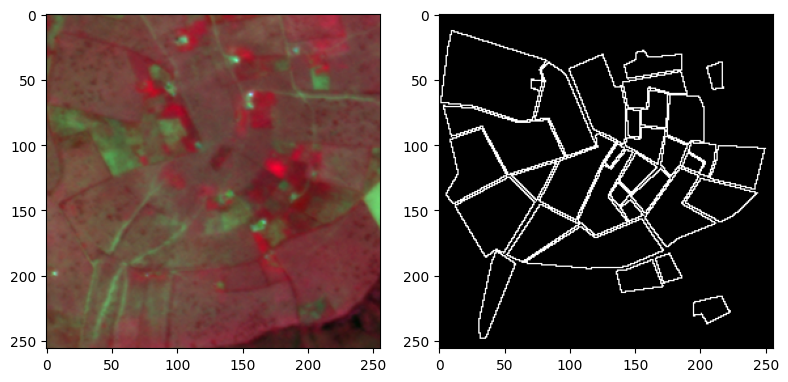

In [21]:
f,m = t_rotation(field, mask, rot=1) #rotation
show_image(f,m)

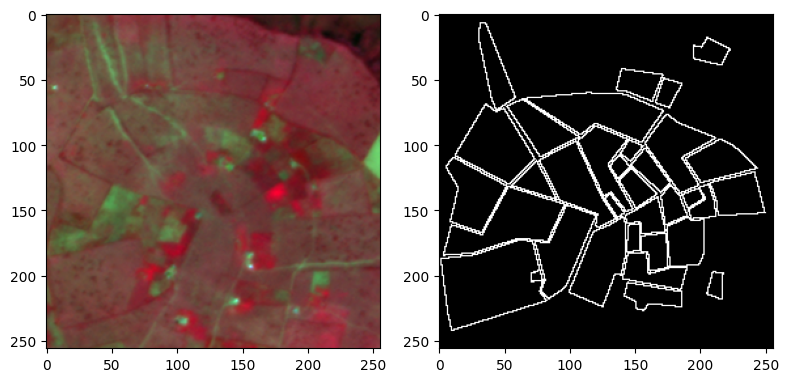

In [22]:
f,m = t_flip(field, mask, idx=0) #flipping
show_image(f,m)

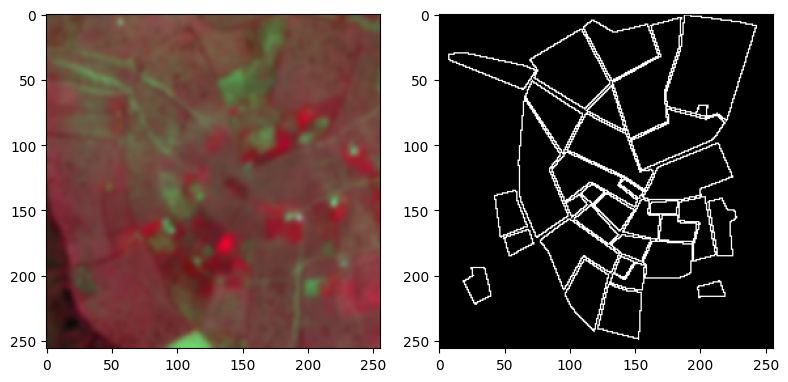

In [23]:
f,m = t_blur(field, mask, sigma=5) #blur
show_image(f,m)

In [24]:
def generate(
    field: np.ndarray,
    mask: np.ndarray,
    write_folder: Path,
    prefix: str = "",
) -> None:
    """
    Generate data augmentations of the provided field and corresponding mask which includes:
     - Linear (no) transformation
     - Rotation
     - Horizontal or vertical flip
     - Gaussian filter (blur)
    :param field: Input array of the field to augment
    :param mask: Input array of the corresponding mask to augment
    :param write_folder: Folder (path) to write the results (augmentations) to
    :param prefix: Field-specific prefix used when writing the augmentation results
    """
    # Generate transformations
    f, m = [0,1,2,3], [0,1,2,3] #dummy data. will be replaced
    f[0],m[0] = t_linear(field, mask) #no augmentation
    f[1],m[1] = t_rotation(field, mask, rot=1) #rotation
    f[2],m[2] = t_flip(field, mask, idx=0) #flipping
    f[3],m[3] = t_blur(field, mask, sigma=5) #blur
    for i in range(len(f)):        
        with open(write_folder +'/'+ f"fields/{str(prefix).zfill(2)}_{i}.pkl", 'wb') as handle:
            pickle.dump(f[i], handle, protocol=pickle.HIGHEST_PROTOCOL)

        with open(write_folder +'/'+ f"masks/{str(prefix).zfill(2)}_{i}.pkl", 'wb') as handle:
            pickle.dump(m[i], handle, protocol=pickle.HIGHEST_PROTOCOL)

In [25]:
def main(
    field: List[np.ndarray],
    mask: List[np.ndarray],
    prefix: List[str],
    write_folder: Path,
) -> None:
    """
    Generate and save data augmentations for all the fields and corresponding masks with the following:
     - Linear (no) transformation
     - Rotation
     - Horizontal or vertical flip
     - Gaussian filter (blur)
     - Gamma filter (brightness)
    :param fields: Fields to augment
    :param masks: Corresponding masks to augment
    :param prefixes: Field-specific prefixes corresponding each field
    :param write_folder: Path to write the results (augmentations) to
    """
    generate(
        field=field,
        mask=mask,
        prefix=prefix,
        write_folder=write_folder,
    )

In [26]:
#apply augmentation effects to training set
for tile in train_tiles:
    bd1 = rio.open(f"{train_source_items}/{dataset_id}_source_train_{tile}/B01.tif")
    bd1_array = bd1.read(1)
    bd2 = rio.open(f"{train_source_items}/{dataset_id}_source_train_{tile}/B02.tif")
    bd2_array = bd2.read(1)
    bd3 = rio.open(f"{train_source_items}/{dataset_id}_source_train_{tile}/B03.tif")
    bd3_array = bd3.read(1)
    bd4 = rio.open(f"{train_source_items}/{dataset_id}_source_train_{tile}/B04.tif")
    bd4_array = bd4.read(1)
    b01_norm = normalize(bd1_array)
    b02_norm = normalize(bd2_array)
    b03_norm = normalize(bd3_array)
    b04_norm = normalize(bd4_array)

    ids_list  = tile.split('_') # XX_YYYY_MM where XX is the training file id and YYYY_MM is the timestamp
    tile_id   = ids_list[0]
    timestamp = f"{ids_list[1]}_{ids_list[2]}"

    field = np.dstack((b04_norm, b03_norm, b02_norm, b01_norm))
    mask  = rio.open(Path.cwd() / f"{train_label_items}/{dataset_id}_labels_train_{tile_id}/raster_labels.tif").read(1) 

    #create a folder for the augmented images
    if not os.path.isdir(f"./augmented_data/{timestamp}"):
        os.makedirs(f"./augmented_data/{timestamp}")
    if not os.path.isdir(f"./augmented_data/{timestamp}/fields"):
        os.makedirs(f"./augmented_data/{timestamp}/fields")
    if not os.path.isdir(f"./augmented_data/{timestamp}/masks"):
        os.makedirs(f"./augmented_data/{timestamp}/masks")

    main( #applying augmentation effects
        field  = field,
        mask   = mask,
        prefix = tile_id,
        write_folder = f"./augmented_data/{timestamp}"
    ) #approximately 30 seconds

In [27]:
timestamps = next(os.walk(f"./augmented_data"))[1] #Get all timestamps
augmented_files = next(os.walk(f"./augmented_data/{timestamps[0]}/fields"))[2] #Get all augmented tile ids. can just use one timestamp
X = np.empty((len(augmented_files), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS*len(timestamps)), dtype=np.float32) #time-series image
y = np.empty((len(augmented_files), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.uint8) #mask for each scene
i = 0
for file in augmented_files:
    idx = 0
    augmented_id = file.split('.pkl')[0] #id without .pkl extension
    temporal_fields = []
    for timestamp in timestamps:
        with open(f"./augmented_data/{timestamp}/fields/{augmented_id}.pkl", 'rb') as field:
            field = pickle.load(field) 
        X[i][:,:,idx:idx+IMG_CHANNELS] = field
        idx += IMG_CHANNELS
    with open(f"./augmented_data/{timestamp}/masks/{augmented_id}.pkl", 'rb') as mask:
        mask = pickle.load(mask)
    y[i] = mask.reshape(IMG_HEIGHT, IMG_WIDTH, 1)
    i+=1

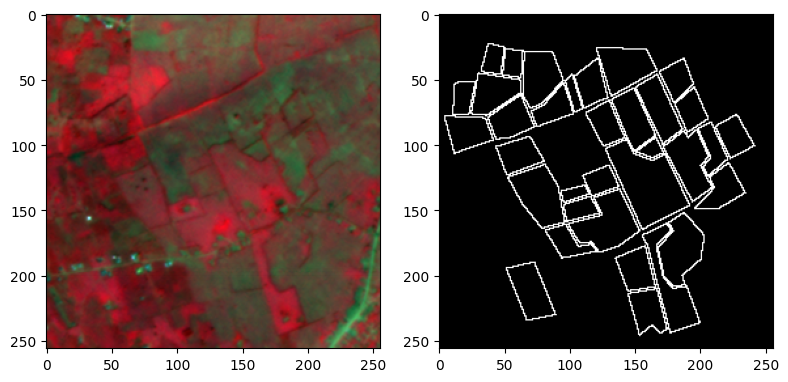

In [28]:
random.randint(0, len(augmented_files)) #sanity check
random_image = random.randint(0, len(augmented_files)-1)
show_image(X[random_image][:,:,0:3], y[random_image])

### Model Training

We decided to use U-Net as it has shown impressive results over multiple domains in image segmentation.
We will employ a ResNet34 backbone with our spatio-temporal U-Net model.

This uses our 24 channels (6 timestamps * 4 bands per timestamp) and generates the predicted field boundary per scene.

We will also use an 80:20 train:validation set split for model training.

Since this is a binary segmentation problem (field boundary or no field boundary), we will use the `binary cross_entropy` loss.

In [29]:
#BACKBONE = 'resnet34'
#preprocess_input = sm.get_preprocessing(BACKBONE)
from tensorflow import keras
from tensorflow.keras import layers

In [30]:
def get_model(input_shape):
    inputs = keras.Input(shape=input_shape)
    
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(1, 1, activation="relu", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model


In [ ]:
#X = preprocess_input(X)

In [31]:
#https://github.com/sustainlab-group/ParcelDelineation/blob/master/models/unet.py
def unet(pretrained_weights = None,input_size = (256,256,4)):
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = Model(input = inputs, output = conv10)

    if(pretrained_weights):
    	model.load_weights(pretrained_weights)

    return 

In [32]:
def learning_rate_scheduler(epoch):
    lr = 1e-4
    
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 150:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    
    print("Set Learning Rate : {}".format(lr))
    return lr

In [33]:
num_channels = 24
input_shape = (256,256,num_channels)
batch_size = 2


For the model, we will make use of two key metrics: **Recall** and **F1-score**.

**Recall** evaluates how much of the field boundaries which were labelled were actually predicted as well while the **f1-score** combines the precision and recall by evaluating the harmonic mean.

**NOTE** that the recall is the more important metric for this case as we are mostly concerned about the retrieved field boundaries out of the labelled field boundaries.

In [34]:
#https://datascience.stackexchange.com/questions/45165/how-to-get-accuracy-f1-precision-and-recall-for-a-keras-model
def recall(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall
def f1(y_true, y_pred):
    def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall_   = recall(y_true, y_pred)
    return 2*((precision*recall_)/(precision+recall_+K.epsilon()))

In [35]:
model = None 
#model_unet = Unet(BACKBONE, encoder_weights='imagenet')
model_unet = get_model((256,256,4))
new_model = keras.models.Sequential()
new_model.add(Conv2D(4, (1,1), padding='same', activation='relu', input_shape=input_shape))
new_model.add(model_unet)
model = new_model 
#sm.metrics.FScore(beta=1)
model.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=learning_rate_scheduler(0)),
              metrics=[recall,f1])

2023-01-28 07:41:54.359171: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Set Learning Rate : 0.0001


In [36]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 256, 256, 4)       100       
                                                                 
 model (Functional)          (None, 256, 256, 1)       2058433   
                                                                 
Total params: 2,058,533
Trainable params: 2,054,757
Non-trainable params: 3,776
_________________________________________________________________


In [37]:
x_train, x_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [38]:
tf.config.experimental_run_functions_eagerly(True)

Instructions for updating:
Use `tf.config.run_functions_eagerly` instead of the experimental version.


In [39]:
history = model.fit(x=x_train, y=y_train,
              validation_data=(x_val, y_val),
              steps_per_epoch = len(x_train)//batch_size,
              validation_steps = len(x_val)//batch_size,
              batch_size=batch_size, epochs=200)

Epoch 1/200


2023-01-28 07:42:11.215102: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 1145044992 exceeds 10% of free system memory.
/home/elie/miniconda3/envs/zindi/lib/python3.8/site-packages/tensorflow/python/data/ops/structured_function.py:256: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
2023-01-28 07:42:12.034021: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 18874368 exceeds 10% of free system memory.
2023-01-28 07:42:12.053009: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 18874368 exceeds 10% of free system memory.
2023-01-28 07:42:12.066149: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 33554432 exceeds 10% of free system memory.
2023-01-28 07:42:12.154983: W tensorflow/tsl/framework/cpu_allocato

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
91/91 [==============================] - 60s 651ms/step - loss: 0.4028 - recall: 0.0413 - f1: 0.0301 - val_loss: 0.2206 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00
Epoch 2/200
91/91 [==============================] - 63s 693ms/step - loss: 0.2273 - recall: 0.0128 - f1: 0.0198 - val_loss: 0.2809 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00
Epoch 3/200
91/91 [==============================] - 74s 814ms/step - loss: 0.2104 - recall: 0.0063 - f1: 0.0110 - val_loss: 0.3595 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00
Epoch 4/200
91/91 [==============================] - 72s 792ms/step - loss: 0.2041 - recall: 0.0055 - f1: 0.0094 - val_loss: 0.3460 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00
Epoch 5/200
91/91 [==============================] - 78s 861ms/step - loss: 0.1998 - recall: 0.0022

In [40]:
model.save(f"./unet_model.h5")


In [ ]:
model = load_model(f"./unet_model.h5", custom_objects ={"recall":sm.metrics.Recall(threshold=0.5), "f1": f1})

### Loading test chips to run predictions

In [41]:
test_source_items = f"{dataset_id}/{dataset_id}_source_test"
test_tiles = [clean_string(s) for s in next(os.walk(test_source_items))[1]]

In [42]:
test_tile_ids = set()
for tile in test_tiles:
    test_tile_ids.add(tile.split('_')[0])

In [43]:
X_test = np.empty((len(test_tile_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS*len(timestamps)), dtype=np.float32)
i = 0
loaded_tiles = []
for tile_id in test_tile_ids:
    idx = 0
    for timestamp in timestamps:
        bd1 = rio.open(f"{test_source_items}/{dataset_id}_source_test_{tile_id}_{timestamp}/B01.tif")
        bd1_array = bd1.read(1)
        bd2 = rio.open(f"{test_source_items}/{dataset_id}_source_test_{tile_id}_{timestamp}/B02.tif")
        bd2_array = bd2.read(1)
        bd3 = rio.open(f"{test_source_items}/{dataset_id}_source_test_{tile_id}_{timestamp}/B03.tif")
        bd3_array = bd3.read(1)
        bd4 = rio.open(f"{test_source_items}/{dataset_id}_source_test_{tile_id}_{timestamp}/B04.tif")
        bd4_array = bd4.read(1)
        b01_norm = normalize(bd1_array)
        b02_norm = normalize(bd2_array)
        b03_norm = normalize(bd3_array)
        b04_norm = normalize(bd4_array)
        
        field = np.dstack((b04_norm, b03_norm, b02_norm, b01_norm))
        X_test[i][:,:,idx:idx+IMG_CHANNELS] = field
        idx+=IMG_CHANNELS
    loaded_tiles.append(str(tile_id).zfill(2)) #track order test tiles are loaded into X to make sure tile id matches 
    i+=1

In [44]:
predictions_dictionary = {}
for i in range(len(test_tile_ids)):
    model_pred = model.predict(np.expand_dims(X_test[i], 0))
    model_pred = model_pred[0]
    model_pred = (model_pred >= 0.5).astype(np.uint8)
    model_pred = model_pred.reshape(IMG_HEIGHT, IMG_WIDTH)
    predictions_dictionary.update([(str(loaded_tiles[i]), pd.DataFrame(model_pred))])

1/1 [==============================] - 0s 116ms/step


In [45]:
dfs = []
for key, value in predictions_dictionary.items():
    ftd = value.unstack().reset_index().rename(columns={'level_0': 'row', 'level_1': 'column', 0: 'label'})
    ftd['tile_row_column'] = f'Tile{key}_' + ftd['row'].astype(str) + '_' + ftd['column'].astype(str)
    ftd = ftd[['tile_row_column', 'label']]
    dfs.append(ftd)

sub = pd.concat(dfs)
sub

,tile_row_column,label
0,Tile10_0_0,0
1,Tile10_0_1,0
2,Tile10_0_2,0
3,Tile10_0_3,0
4,Tile10_0_4,0
...,...,...
65531,Tile06_255_251,0
65532,Tile06_255_252,0
65533,Tile06_255_253,0
65534,Tile06_255_254,0


In [46]:
sub.to_csv(f"./harvest_sample_submission.csv", index = False)

In [50]:
sub.groupby('label').count()


,tile_row_column
label,
0,843504
1,8464
